In [57]:
# imports
from csv import DictReader, DictWriter
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
original_column_names = ['station_id', 'longitude', 'latitude', 'time', 'AtmospherePressure', 'WindDirection', 'WindSpeed', 'Gust', 'WaveHeight', 'WavePeriod', 'MeanWaveDirection', 'Hmax', 'AirTemperature', 'DewPoint', 'SeaTemperature', 'RelativeHumidity']

new_column_names = ['AtmospherePressure', 'WindDirection', 'WindSpeed', 'Gust', 'AirTemperature', 'RelativeHumidity', 'WaveHeight']

In [59]:
with open('../data/raw_data.csv', 'r') as f1, open('../data/interim_data.csv', 'w') as f2:
    reader = DictReader(f1, fieldnames=original_column_names)
    writer = DictWriter(f2, fieldnames=new_column_names, lineterminator='\n')

    next(reader)
    next(reader)

    writer.writeheader()

    for line in tqdm(reader):
        if any(line[column_name] == 'NaN' for column_name in new_column_names):
            continue
        writer.writerow({column_name: line[column_name] for column_name in new_column_names})

613392it [00:02, 285501.66it/s]


In [60]:
df = pd.read_csv('../data/interim_data.csv')
df.describe()

,AtmospherePressure,WindDirection,WindSpeed,Gust,AirTemperature,RelativeHumidity,WaveHeight
count,403845.000000,403845.000000,403845.000000,403845.000000,403845.00000,403845.000000,403845.000000
mean,1013.774914,206.758608,15.104633,21.405105,11.61408,82.416231,2.289677
std,12.234193,89.428016,6.875784,9.522440,2.87607,9.714247,1.523549
min,909.900000,0.000000,0.000000,0.000000,0.26400,0.391000,0.078000
25%,1006.400000,150.000000,10.000000,14.658000,9.50000,75.391000,1.200000
50%,1015.000000,220.000000,15.000000,20.000000,11.60000,83.000000,1.953000
75%,1022.290000,271.000000,19.781000,27.000000,14.00000,90.000000,3.000000
max,1046.400000,360.000000,76.506000,200.000000,26.17200,100.000000,14.100000


In [61]:
# Use the interquartile range to remove the outliers in data.
for column_name in new_column_names:
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5*IQR
    upper_whisker = Q3 + 1.5*IQR
    df = df[(df[column_name] >= lower_whisker) & (df[column_name] <= upper_whisker)]

In [62]:
# Feature engineering
azimuth_rad = np.deg2rad(df['WindDirection'])
df['WindDirectionSin'] = np.sin(azimuth_rad)
df['WindDirectionCos'] = np.cos(azimuth_rad)
df = df.drop(columns=['WindDirection'])

df = df[['AtmospherePressure', 'WindSpeed', 'Gust', 'RelativeHumidity', 'WindDirectionSin', 'WindDirectionCos', 'AirTemperature', 'WaveHeight']]

df.describe()

,AtmospherePressure,WindSpeed,Gust,RelativeHumidity,WindDirectionSin,WindDirectionCos,AirTemperature,WaveHeight
count,378551.000000,378551.000000,378551.000000,378551.000000,378551.000000,378551.000000,378551.000000,378551.000000
mean,1014.768286,14.465392,20.374661,82.731325,-0.226906,-0.155505,11.724571,2.057696
std,11.285860,6.284241,8.417713,9.571322,0.668922,0.690563,2.874487,1.164179
min,982.593000,0.000000,0.000000,53.516000,-1.000000,-1.000000,2.896000,0.078000
25%,1007.600000,10.000000,14.000000,76.000000,-0.866025,-0.848048,9.600000,1.200000
50%,1015.600000,14.000000,20.000000,83.594000,-0.342020,-0.342020,11.800000,1.800000
75%,1022.620000,19.000000,25.189000,90.234000,0.342020,0.500000,14.100000,2.734000
max,1045.800000,33.016000,46.251000,100.000000,1.000000,1.000000,20.771000,5.430000


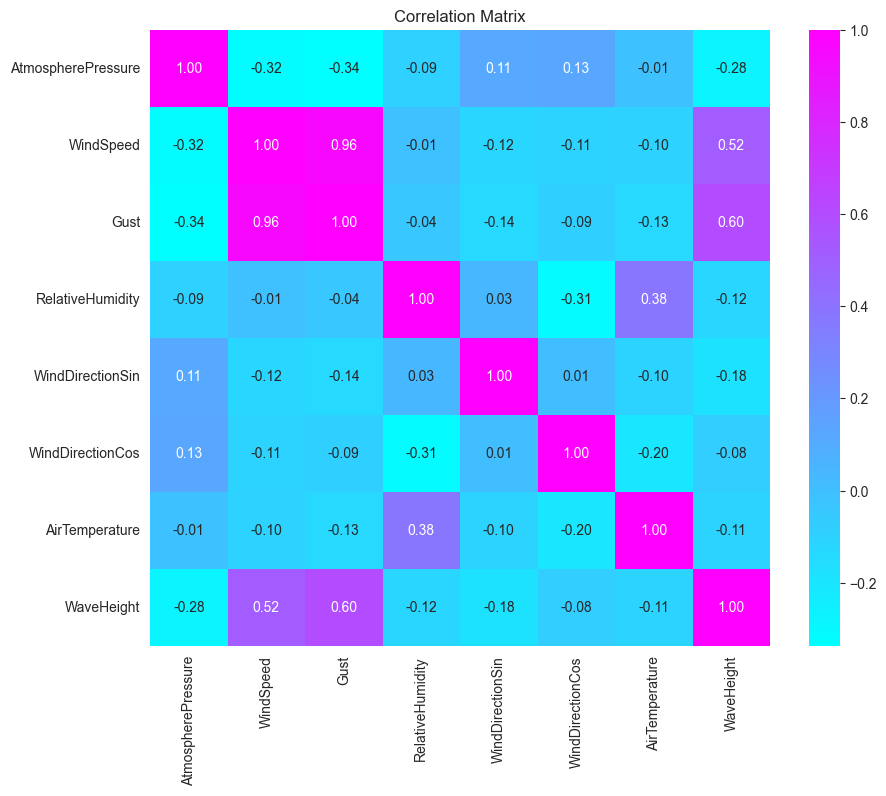

In [63]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="cool", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [64]:
df.to_csv('../data/processed_data.csv', index=False)